Autor: Vicente Córdova

Fecha: 23/06/2024

Modelo uni-step univariado sobre predicción de bolsa Nike

# 1. Introducción

Examen 2 hecho para el ramo Ciencia de datos sobre redes recurrentes, especificamente redes LSTM sobre la predicción de la bolsa.

# 2. Dataset

En este caso el "dataset" es una api de yahoo finance para lograr ver los valores en la bolsa en este caso sobre la marca NIKE.

# 3. Problema a resolver

Crear y entrenar una Red LSTM usando el enfoque univariado + single-step:

# 4. Lectura del dataset

In [1]:
!pip install yfinance

In [2]:
import yfinance as yahooFinance

GetNikeInformation = yahooFinance.Ticker("NKE")

# Let us  get historical stock prices for Facebook
# covering the past few years.
# max->maximum number of daily prices available
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y,
# 5y, 10y and ytd.
print(GetNikeInformation.history(period="10y"))

                                Open       High        Low      Close  \
Date                                                                    
2014-06-23 00:00:00-04:00  33.593637  33.821771  33.280516  33.750198   
2014-06-24 00:00:00-04:00  33.723381  33.982827  33.517615  33.539982   
2014-06-25 00:00:00-04:00  33.562338  34.237790  33.562338  34.206478   
2014-06-26 00:00:00-04:00  34.251209  34.403299  33.848621  34.380932   
2014-06-27 00:00:00-04:00  35.127943  35.405282  34.747723  34.747723   
...                              ...        ...        ...        ...   
2024-06-14 00:00:00-04:00  93.800003  94.779999  93.300003  93.389999   
2024-06-17 00:00:00-04:00  92.010002  95.120003  92.010002  95.000000   
2024-06-18 00:00:00-04:00  94.669998  95.260002  94.209999  94.779999   
2024-06-20 00:00:00-04:00  93.879997  96.089996  93.519997  95.570000   
2024-06-21 00:00:00-04:00  95.959999  97.209999  95.419998  97.180000   

                             Volume  Dividends  St

In [3]:
df = GetNikeInformation.history(period="10y")

In [4]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

En este caso podemos ver que los valores de la bolsa tratan de 10 años, no hay errores en las columnas y como solo nos interesa el precio de cuando termino el dia podriamos decir que no hay que tratar mayormente los datos.

# 5. Pre-procesamiento

## 5.1 Separar los datos en test, train y val

In [5]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df['Close'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2013,)
Tamaño set de validación: (251,)
Tamaño set de prueba: (253,)


In [6]:
tr.head()

Date
2014-06-23 00:00:00-04:00    33.750198
2014-06-24 00:00:00-04:00    33.539982
2014-06-25 00:00:00-04:00    34.206478
2014-06-26 00:00:00-04:00    34.380932
2014-06-27 00:00:00-04:00    34.747723
Name: Close, dtype: float64

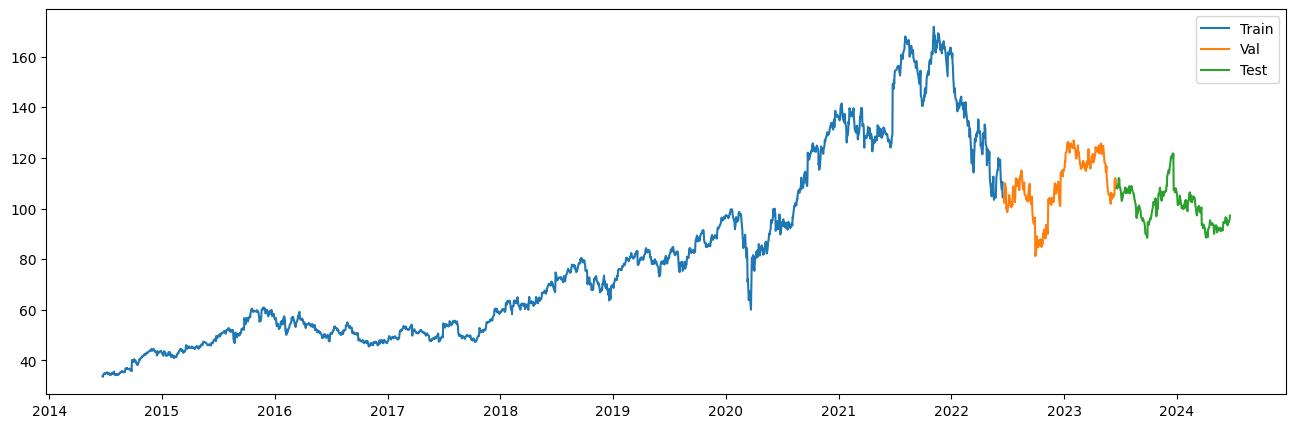

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import tensorflow
from numpy.random import seed

seed(1)
tensorflow.random.set_seed(2)

## 5.2 Crear el dataset supervisado

In [9]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [10]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 21   # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1991, 21, 1), y_tr: (1991, 1, 1)
Set de validación - x_vl: (229, 21, 1), y_vl: (229, 1, 1)
Set de prueba - x_ts: (231, 21, 1), y_ts: (231, 1, 1)


## 5.3 Escalando los datos

In [11]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [12]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 33.539981842041016/81.19963836669922/88.4570083618164
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.31633203948950106/-0.2108705277172147

Min y_tr/y_vl/y_ts sin escalamiento: 34.152793884277344/81.19963836669922/88.4570083618164
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.31633203948950106/-0.2108705277172147

Max x_tr/x_vl/x_ts sin escalamiento: 171.78347778320312/126.89641571044922/121.72769927978516
Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000002/0.3506086956617718/0.27583170314613215

Max y_tr/y_vl/y_ts sin escalamiento: 171.78347778320312/126.89641571044922/121.72769927978516
Max y_tr/y_vl/y_ts con escalamiento: 1.0000000000000002/0.34771722698525/0.2726072837045801


# 6. Creación y entrenamiento del modelo

## 6.1 Modelo 1

Hyperparametros en este modelo
1era capa de 128 neuronas y finalmente la de salida, 80 epocas y 128 de batch size

In [13]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
16/16 - 8s - loss: 0.5090 - val_loss: 0.1643 - 8s/epoch - 522ms/step
Epoch 2/80
16/16 - 0s - loss: 0.4343 - val_loss: 0.1566 - 121ms/epoch - 8ms/step
Epoch 3/80
16/16 - 0s - loss: 0.3586 - val_loss: 0.1508 - 132ms/epoch - 8ms/step
Epoch 4/80
16/16 - 0s - loss: 0.2718 - val_loss: 0.1472 - 130ms/epoch - 8ms/step
Epoch 5/80
16/16 - 0s - loss: 0.1800 - val_loss: 0.1403 - 128ms/epoch - 8ms/step
Epoch 6/80
16/16 - 0s - loss: 0.1154 - val_loss: 0.1133 - 124ms/epoch - 8ms/step
Epoch 7/80
16/16 - 0s - loss: 0.0865 - val_loss: 0.0935 - 143ms/epoch - 9ms/step
Epoch 8/80
16/16 - 0s - loss: 0.0692 - val_loss: 0.0824 - 119ms/epoch - 7ms/step
Epoch 9/80
16/16 - 0s - loss: 0.0587 - val_loss: 0.0791 - 122ms/epoch - 8ms/step
Epoch 10/80
16/16 - 0s - loss: 0.0541 - val_loss: 0.0781 - 137ms/epoch - 9ms/step
Epoch 11/80
16/16 - 0s - loss: 0.0527 - val_loss: 0.0786 - 125ms/epoch - 8ms/step
Epoch 12/80
16/16 - 0s - loss: 0.0520 - val_loss: 0.0769 - 173ms/epoch - 11ms/step
Epoch 13/80
16/16 - 0s - 

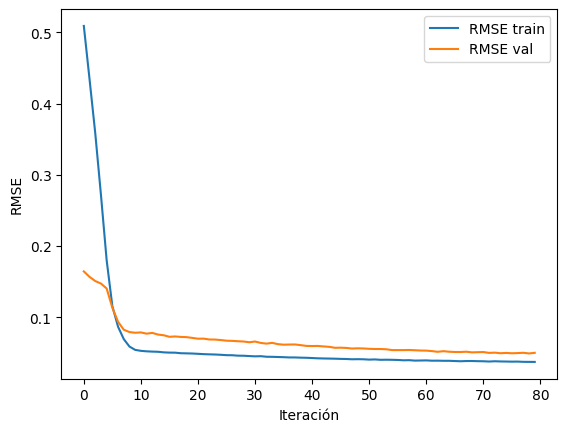

In [14]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [15]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.030
  RMSE val:	 0.049
  RMSE test:	 0.040


In [16]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [17]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

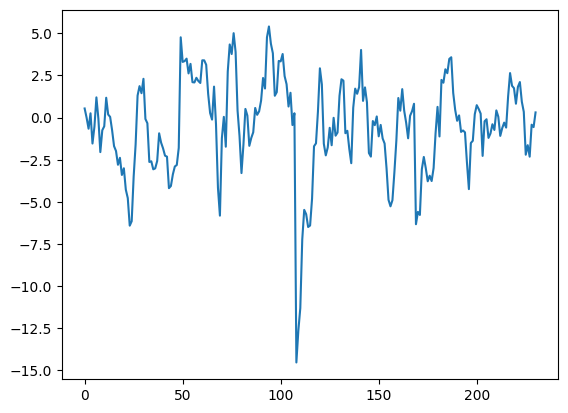

In [18]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [19]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [20]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.985733
2024-06-14    107.247032
2024-06-15    107.436226
2024-06-16    107.507988
2024-06-17    107.694977
                 ...    
2025-01-25     95.817688
2025-01-26     95.710930
2025-01-27     95.422852
2025-01-28     95.346443
2025-01-29     95.264420
Length: 231, dtype: float32


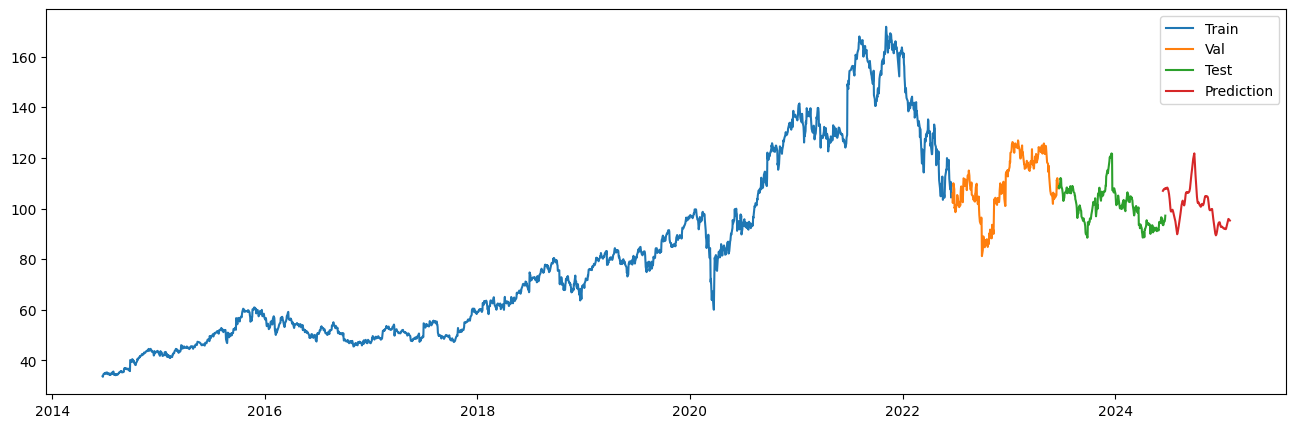

In [21]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.2 modelo 2

Hyperparametros en este modelo
1era capa de 128 neuronas, segunda capa de 64 neuronar, tercera capa de 32 neuronas, todas con activación linear, y finalmente la de salida, 100 epocas y 32 de batch size

In [22]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo2 = Sequential()
modelo2.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo2.add(Dense(64, activation='linear'))
modelo2.add(Dense(32, activation='linear'))
modelo2.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo2.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 32 # Hiperparámetro
historia = modelo2.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
63/63 - 3s - loss: 0.3014 - val_loss: 0.0923 - 3s/epoch - 40ms/step
Epoch 2/100
63/63 - 0s - loss: 0.0507 - val_loss: 0.0642 - 288ms/epoch - 5ms/step
Epoch 3/100
63/63 - 0s - loss: 0.0445 - val_loss: 0.0607 - 293ms/epoch - 5ms/step
Epoch 4/100
63/63 - 0s - loss: 0.0425 - val_loss: 0.0586 - 300ms/epoch - 5ms/step
Epoch 5/100
63/63 - 0s - loss: 0.0415 - val_loss: 0.0574 - 287ms/epoch - 5ms/step
Epoch 6/100
63/63 - 0s - loss: 0.0395 - val_loss: 0.0543 - 282ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.0383 - val_loss: 0.0519 - 291ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.0374 - val_loss: 0.0502 - 281ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.0364 - val_loss: 0.0491 - 283ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.0354 - val_loss: 0.0484 - 301ms/epoch - 5ms/step
Epoch 11/100
63/63 - 0s - loss: 0.0345 - val_loss: 0.0476 - 287ms/epoch - 5ms/step
Epoch 12/100
63/63 - 0s - loss: 0.0340 - val_loss: 0.0452 - 282ms/epoch - 4ms/step
Epoch 13/100
63

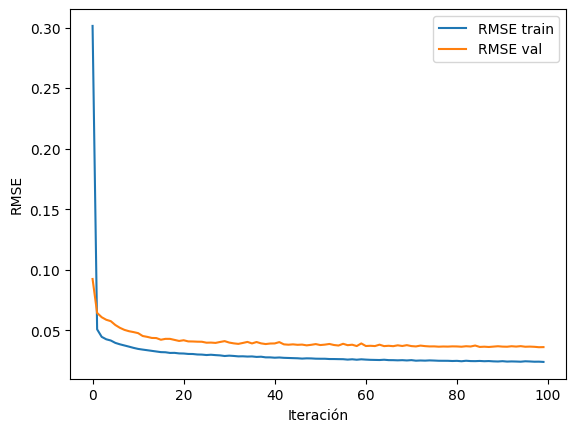

In [23]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [24]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo2.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo2.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.022
  RMSE val:	 0.036
  RMSE test:	 0.025


In [25]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo2, scaler)

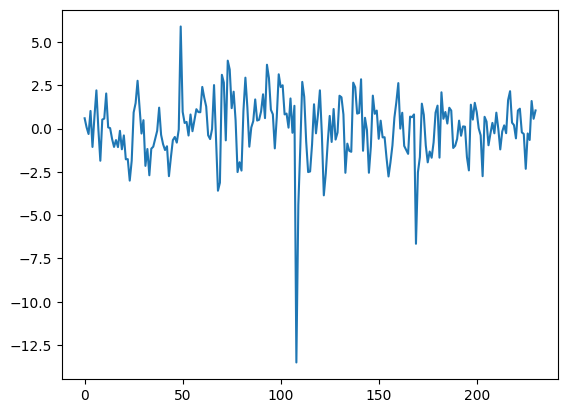

In [26]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [27]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [28]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.931587
2024-06-14    107.170486
2024-06-15    107.090576
2024-06-16    106.744431
2024-06-17    107.216492
                 ...    
2025-01-25     94.462227
2025-01-26     94.051231
2025-01-27     93.410400
2025-01-28     94.216682
2025-01-29     94.524467
Length: 231, dtype: float32


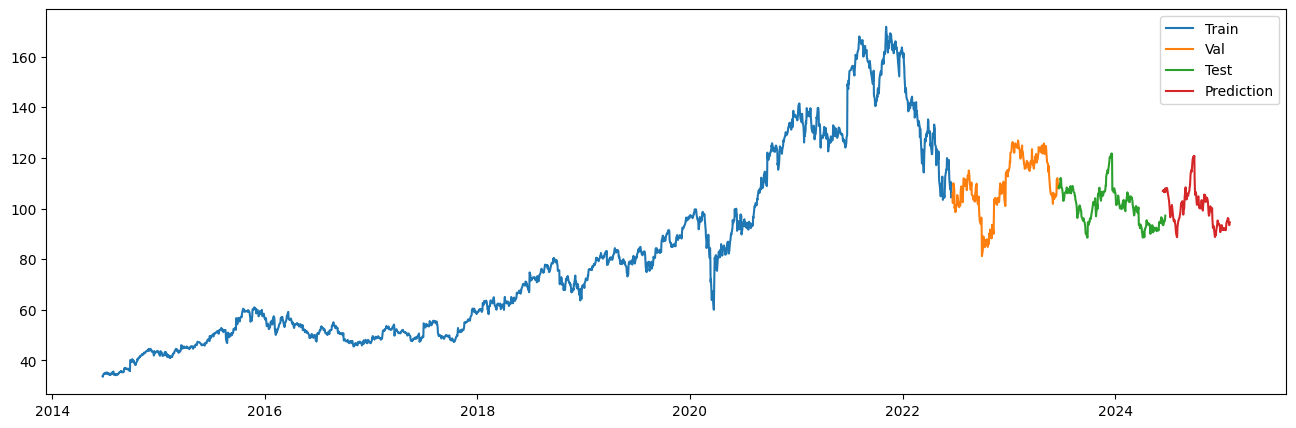

In [29]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.3 modelo 3

Hyperparametros en este modelo
1era capa de 128 neuronas, segunda capa de 64 neuronas, con activación linear, y finalmente la de salida, 100 epocas y 32 de batch size

In [30]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo3 = Sequential()
modelo3.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo3.add(Dense(64, activation='linear'))
modelo3.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo3.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 32 # Hiperparámetro
historia = modelo3.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
63/63 - 3s - loss: 0.3588 - val_loss: 0.1220 - 3s/epoch - 45ms/step
Epoch 2/100
63/63 - 0s - loss: 0.0617 - val_loss: 0.0660 - 377ms/epoch - 6ms/step
Epoch 3/100
63/63 - 0s - loss: 0.0458 - val_loss: 0.0629 - 367ms/epoch - 6ms/step
Epoch 4/100
63/63 - 0s - loss: 0.0439 - val_loss: 0.0613 - 355ms/epoch - 6ms/step
Epoch 5/100
63/63 - 0s - loss: 0.0431 - val_loss: 0.0602 - 347ms/epoch - 6ms/step
Epoch 6/100
63/63 - 0s - loss: 0.0413 - val_loss: 0.0572 - 270ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.0402 - val_loss: 0.0551 - 284ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.0394 - val_loss: 0.0536 - 273ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.0384 - val_loss: 0.0526 - 274ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.0374 - val_loss: 0.0519 - 275ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.0365 - val_loss: 0.0510 - 272ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.0359 - val_loss: 0.0486 - 270ms/epoch - 4ms/step
Epoch 13/100
63

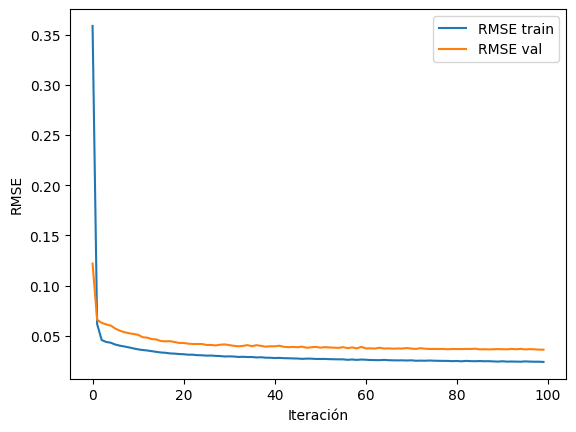

In [31]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [32]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo3.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo3.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo3.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.022
  RMSE val:	 0.036
  RMSE test:	 0.026


In [33]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo3, scaler)

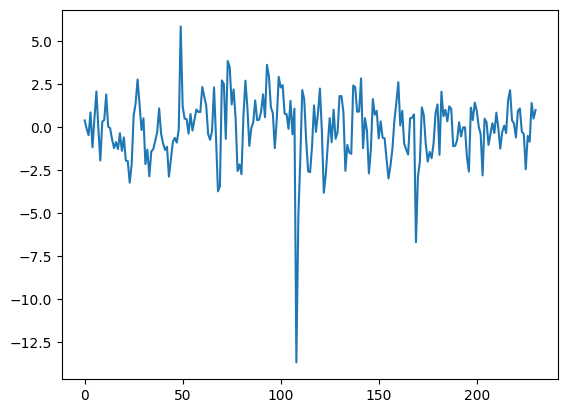

In [34]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [35]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [36]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    107.119598
2024-06-14    107.311119
2024-06-15    107.225365
2024-06-16    106.892593
2024-06-17    107.312523
                 ...    
2025-01-25     94.677246
2025-01-26     94.230202
2025-01-27     93.577675
2025-01-28     94.273499
2025-01-29     94.561668
Length: 231, dtype: float32


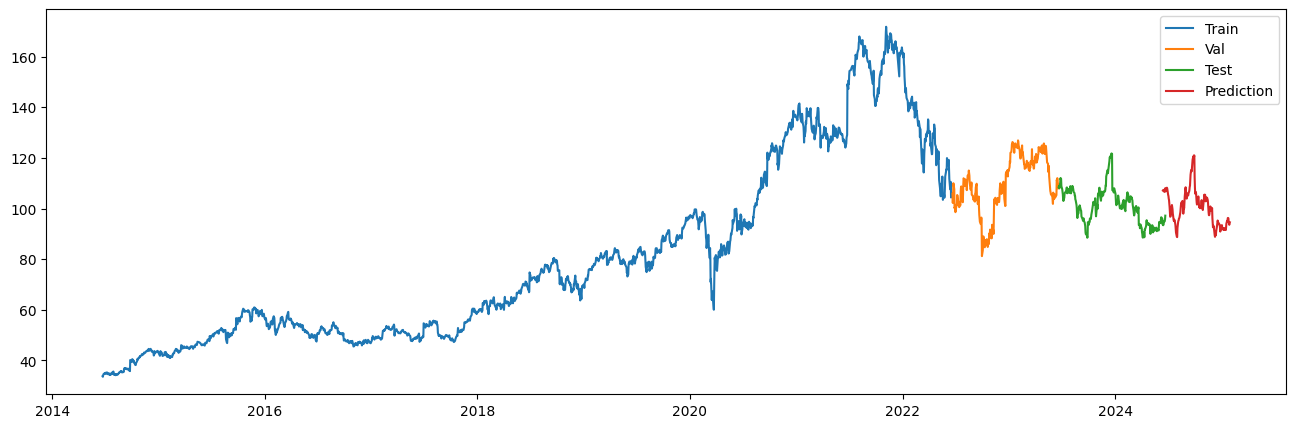

In [37]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.4 Modelo 4

Hyperparametros en este modelo
1era capa de 128 neuronas, segunda capa de 64 neuronas, con activación linear, y finalmente la de salida, 100 epocas y 16 de batch size

In [38]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo4 = Sequential()
modelo4.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo4.add(Dense(64, activation='linear'))
modelo4.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo4.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 16 # Hiperparámetro
historia = modelo4.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
125/125 - 3s - loss: 0.2023 - val_loss: 0.0625 - 3s/epoch - 20ms/step
Epoch 2/100
125/125 - 1s - loss: 0.0427 - val_loss: 0.0586 - 708ms/epoch - 6ms/step
Epoch 3/100
125/125 - 1s - loss: 0.0397 - val_loss: 0.0539 - 753ms/epoch - 6ms/step
Epoch 4/100
125/125 - 1s - loss: 0.0377 - val_loss: 0.0515 - 1s/epoch - 10ms/step
Epoch 5/100
125/125 - 1s - loss: 0.0362 - val_loss: 0.0499 - 1s/epoch - 9ms/step
Epoch 6/100
125/125 - 1s - loss: 0.0346 - val_loss: 0.0472 - 1s/epoch - 10ms/step
Epoch 7/100
125/125 - 1s - loss: 0.0335 - val_loss: 0.0451 - 518ms/epoch - 4ms/step
Epoch 8/100
125/125 - 1s - loss: 0.0325 - val_loss: 0.0442 - 532ms/epoch - 4ms/step
Epoch 9/100
125/125 - 1s - loss: 0.0319 - val_loss: 0.0432 - 505ms/epoch - 4ms/step
Epoch 10/100
125/125 - 0s - loss: 0.0314 - val_loss: 0.0428 - 498ms/epoch - 4ms/step
Epoch 11/100
125/125 - 1s - loss: 0.0312 - val_loss: 0.0418 - 518ms/epoch - 4ms/step
Epoch 12/100
125/125 - 1s - loss: 0.0304 - val_loss: 0.0411 - 510ms/epoch - 4ms/ste

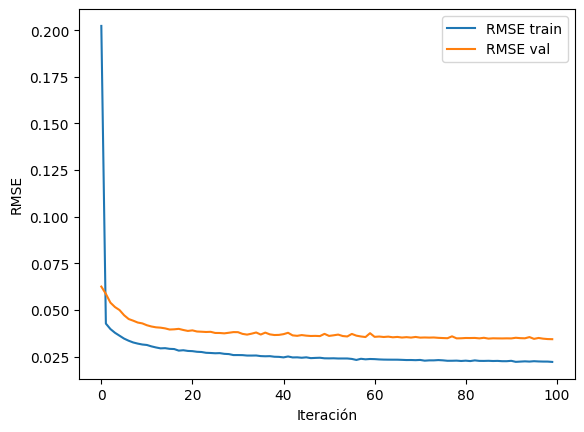

In [39]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [40]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo4.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo4.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo4.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.020
  RMSE val:	 0.035
  RMSE test:	 0.025


In [41]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo4, scaler)

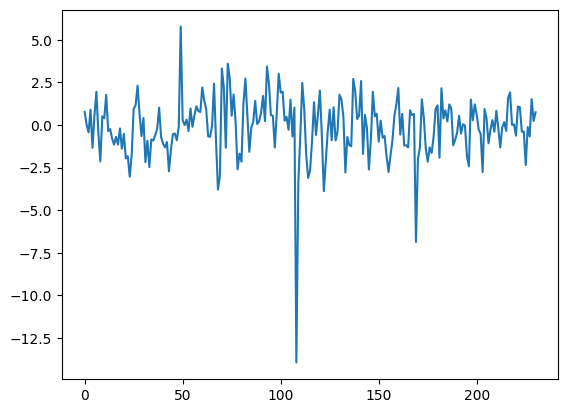

In [42]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [43]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [44]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.749229
2024-06-14    107.222168
2024-06-15    107.204865
2024-06-16    106.859596
2024-06-17    107.486282
                 ...    
2025-01-25     94.293877
2025-01-26     94.059944
2025-01-27     93.475517
2025-01-28     94.540237
2025-01-29     94.822205
Length: 231, dtype: float32


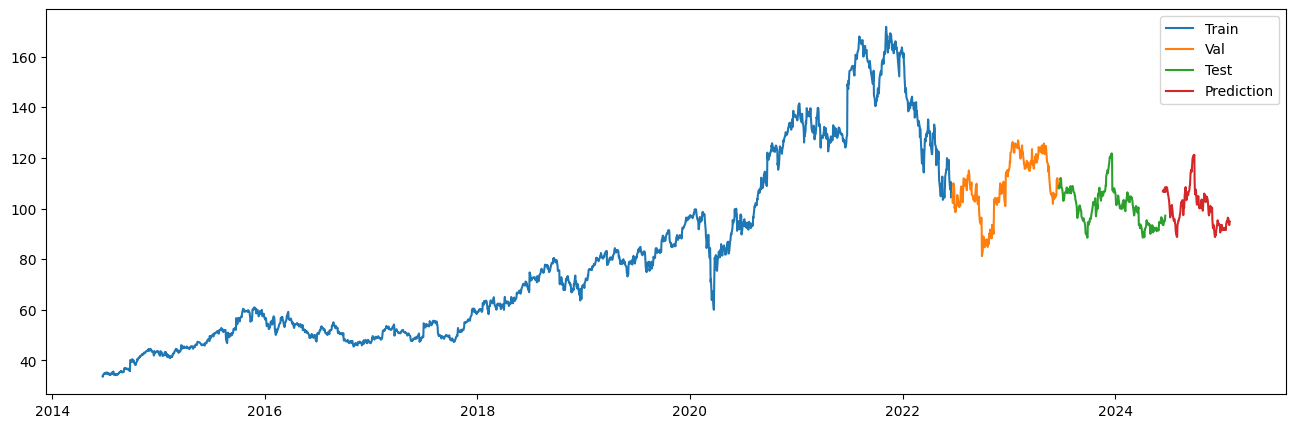

In [45]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.5 Modelo 5

Hyperparametros en este modelo
1era capa de 128 neuronas, segunda capa de 128 neuronas, con activación linear, y finalmente la de salida, 100 epocas y 16 de batch size

In [46]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo5 = Sequential()
modelo5.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo5.add(Dense(128, activation='linear'))
modelo5.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo5.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 16 # Hiperparámetro
historia = modelo5.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
125/125 - 3s - loss: 0.2257 - val_loss: 0.0641 - 3s/epoch - 21ms/step
Epoch 2/100
125/125 - 1s - loss: 0.0438 - val_loss: 0.0596 - 554ms/epoch - 4ms/step
Epoch 3/100
125/125 - 1s - loss: 0.0405 - val_loss: 0.0546 - 539ms/epoch - 4ms/step
Epoch 4/100
125/125 - 0s - loss: 0.0383 - val_loss: 0.0519 - 499ms/epoch - 4ms/step
Epoch 5/100
125/125 - 1s - loss: 0.0365 - val_loss: 0.0502 - 537ms/epoch - 4ms/step
Epoch 6/100
125/125 - 1s - loss: 0.0347 - val_loss: 0.0472 - 542ms/epoch - 4ms/step
Epoch 7/100
125/125 - 1s - loss: 0.0334 - val_loss: 0.0450 - 572ms/epoch - 5ms/step
Epoch 8/100
125/125 - 1s - loss: 0.0323 - val_loss: 0.0438 - 685ms/epoch - 5ms/step
Epoch 9/100
125/125 - 1s - loss: 0.0315 - val_loss: 0.0427 - 682ms/epoch - 5ms/step
Epoch 10/100
125/125 - 1s - loss: 0.0310 - val_loss: 0.0422 - 710ms/epoch - 6ms/step
Epoch 11/100
125/125 - 1s - loss: 0.0307 - val_loss: 0.0410 - 655ms/epoch - 5ms/step
Epoch 12/100
125/125 - 1s - loss: 0.0299 - val_loss: 0.0404 - 518ms/epoch - 

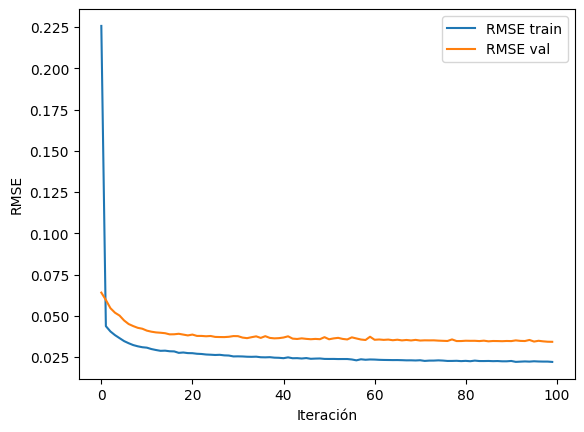

In [47]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [48]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo5.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo5.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo5.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.020
  RMSE val:	 0.035
  RMSE test:	 0.025


In [49]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo5, scaler)

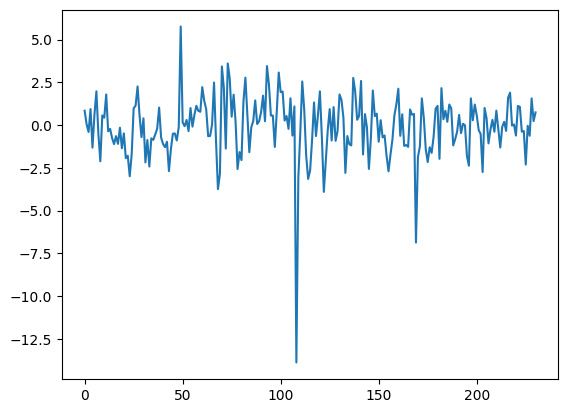

In [50]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [51]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [52]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.688652
2024-06-14    107.191734
2024-06-15    107.179405
2024-06-16    106.829353
2024-06-17    107.476807
                 ...    
2025-01-25     94.223953
2025-01-26     94.016701
2025-01-27     93.440964
2025-01-28     94.550217
2025-01-29     94.830879
Length: 231, dtype: float32


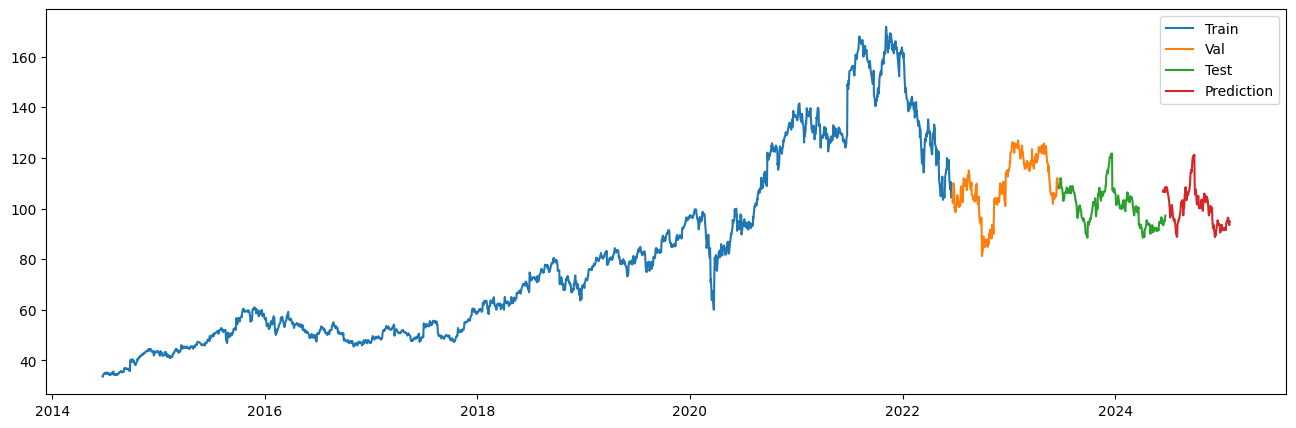

In [53]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.6 Modelo 6

Hyperparametros en este modelo
1era capa de 256 neuronas, segunda capa de 128 neuronas, con activación linear, y finalmente la de salida, 100 epocas y 16 de batch size

In [56]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 256 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo6 = Sequential()
modelo6.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo6.add(Dense(128, activation='linear'))
modelo6.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo6.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 16 # Hiperparámetro
historia = modelo6.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
125/125 - 3s - loss: 0.1146 - val_loss: 0.0641 - 3s/epoch - 22ms/step
Epoch 2/100
125/125 - 1s - loss: 0.0443 - val_loss: 0.0587 - 549ms/epoch - 4ms/step
Epoch 3/100
125/125 - 1s - loss: 0.0405 - val_loss: 0.0525 - 509ms/epoch - 4ms/step
Epoch 4/100
125/125 - 1s - loss: 0.0380 - val_loss: 0.0493 - 552ms/epoch - 4ms/step
Epoch 5/100
125/125 - 1s - loss: 0.0360 - val_loss: 0.0484 - 530ms/epoch - 4ms/step
Epoch 6/100
125/125 - 1s - loss: 0.0341 - val_loss: 0.0448 - 506ms/epoch - 4ms/step
Epoch 7/100
125/125 - 1s - loss: 0.0332 - val_loss: 0.0432 - 700ms/epoch - 6ms/step
Epoch 8/100
125/125 - 1s - loss: 0.0322 - val_loss: 0.0422 - 670ms/epoch - 5ms/step
Epoch 9/100
125/125 - 1s - loss: 0.0315 - val_loss: 0.0417 - 692ms/epoch - 6ms/step
Epoch 10/100
125/125 - 1s - loss: 0.0310 - val_loss: 0.0414 - 702ms/epoch - 6ms/step
Epoch 11/100
125/125 - 1s - loss: 0.0309 - val_loss: 0.0401 - 514ms/epoch - 4ms/step
Epoch 12/100
125/125 - 1s - loss: 0.0298 - val_loss: 0.0397 - 545ms/epoch - 

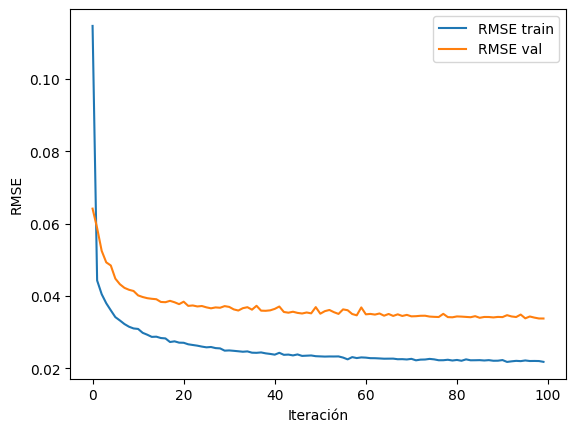

In [57]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [58]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo6.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo6.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo6.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.020
  RMSE val:	 0.034
  RMSE test:	 0.024


In [59]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo6, scaler)

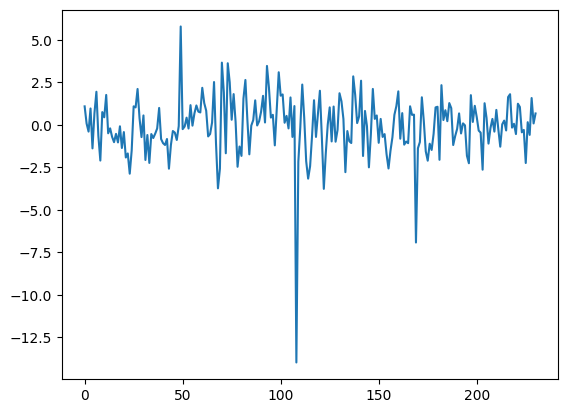

In [60]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [61]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [62]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.436134
2024-06-14    107.160065
2024-06-15    107.169228
2024-06-16    106.796303
2024-06-17    107.537018
                 ...    
2025-01-25     94.022346
2025-01-26     93.978378
2025-01-27     93.420715
2025-01-28     94.695023
2025-01-29     94.898888
Length: 231, dtype: float32


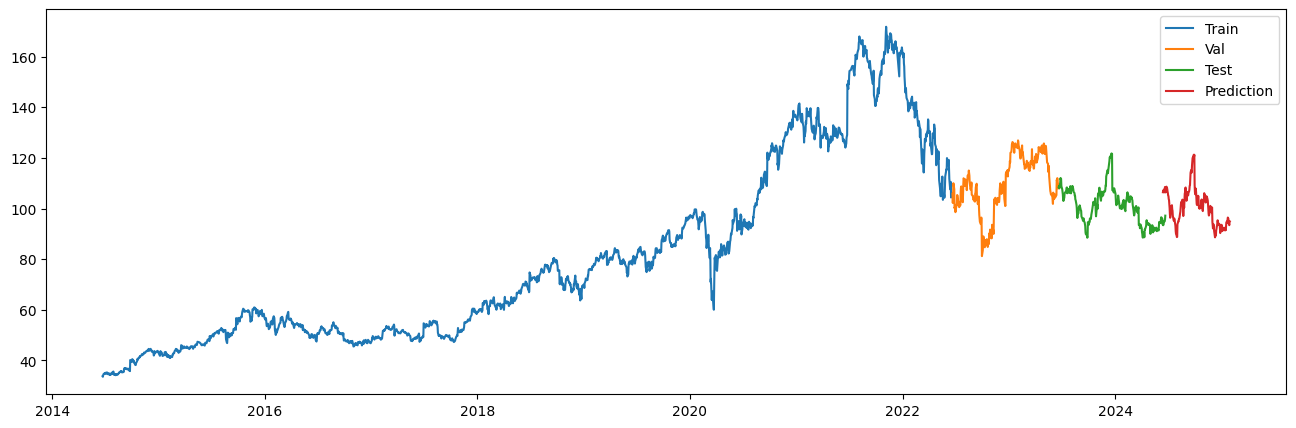

In [63]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.7  modelo 7

Hyperparametros en este modelo
1era capa de 256 neuronas, segunda capa de 128 neuronas, con activación linear, dropout de 0.5 y finalmente la de salida, 100 epocas y 16 de batch size

In [64]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 256 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo7 = Sequential()
modelo7.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo7.add(Dropout(0.5))
modelo7.add(Dense(128, activation='linear'))
modelo7.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo7.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 16 # Hiperparámetro
historia = modelo7.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100
125/125 - 4s - loss: 0.1299 - val_loss: 0.0611 - 4s/epoch - 32ms/step
Epoch 2/100
125/125 - 1s - loss: 0.0741 - val_loss: 0.0579 - 512ms/epoch - 4ms/step
Epoch 3/100
125/125 - 1s - loss: 0.0660 - val_loss: 0.0550 - 546ms/epoch - 4ms/step
Epoch 4/100
125/125 - 1s - loss: 0.0618 - val_loss: 0.0541 - 509ms/epoch - 4ms/step
Epoch 5/100
125/125 - 1s - loss: 0.0604 - val_loss: 0.0513 - 576ms/epoch - 5ms/step
Epoch 6/100
125/125 - 1s - loss: 0.0582 - val_loss: 0.0505 - 577ms/epoch - 5ms/step
Epoch 7/100
125/125 - 1s - loss: 0.0556 - val_loss: 0.0482 - 530ms/epoch - 4ms/step
Epoch 8/100
125/125 - 1s - loss: 0.0537 - val_loss: 0.0490 - 523ms/epoch - 4ms/step
Epoch 9/100
125/125 - 1s - loss: 0.0537 - val_loss: 0.0466 - 543ms/epoch - 4ms/step
Epoch 10/100
125/125 - 1s - loss: 0.0514 - val_loss: 0.0467 - 558ms/epoch - 4ms/step
Epoch 11/100
125/125 - 1s - loss: 0.0518 - val_loss: 0.0450 - 516ms/epoch - 4ms/step
Epoch 12/100
125/125 - 1s - loss: 0.0507 - val_loss: 0.0452 - 518ms/epoch - 

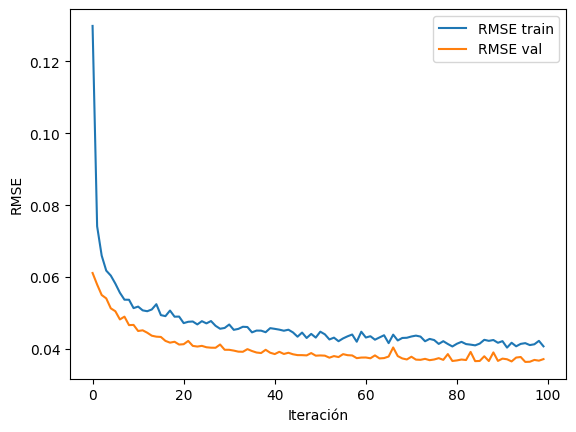

In [65]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [66]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo7.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo7.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo7.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.023
  RMSE val:	 0.038
  RMSE test:	 0.027


In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo7, scaler)

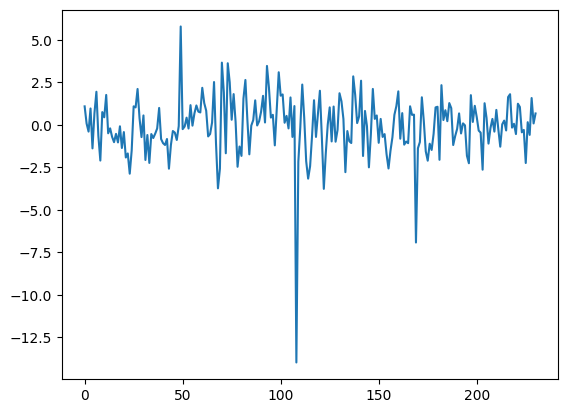

In [67]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [68]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [69]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.436134
2024-06-14    107.160065
2024-06-15    107.169228
2024-06-16    106.796303
2024-06-17    107.537018
                 ...    
2025-01-25     94.022346
2025-01-26     93.978378
2025-01-27     93.420715
2025-01-28     94.695023
2025-01-29     94.898888
Length: 231, dtype: float32


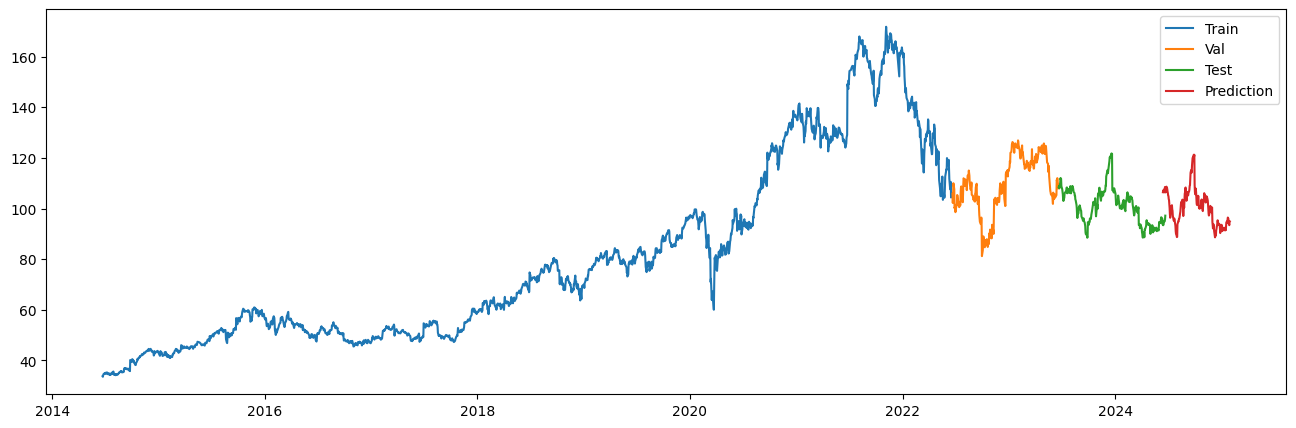

In [70]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

## 6.8 Modelo 8

Hyperparametros en este modelo
1era capa de 512 neuronas, segunda capa de 128 neuronas, con activación linear, y finalmente la de salida, 150 epocas y 16 de batch size

In [72]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 512 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # x 1 (feature)

modelo8 = Sequential()
modelo8.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo8.add(Dense(256, activation='linear'))
modelo8.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo8.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 150 # Hiperparámetro
BATCH_SIZE = 16 # Hiperparámetro
historia = modelo8.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/150
125/125 - 3s - loss: 0.0778 - val_loss: 0.0592 - 3s/epoch - 27ms/step
Epoch 2/150
125/125 - 1s - loss: 0.0432 - val_loss: 0.0552 - 655ms/epoch - 5ms/step
Epoch 3/150
125/125 - 1s - loss: 0.0393 - val_loss: 0.0496 - 544ms/epoch - 4ms/step
Epoch 4/150
125/125 - 1s - loss: 0.0368 - val_loss: 0.0466 - 557ms/epoch - 4ms/step
Epoch 5/150
125/125 - 1s - loss: 0.0350 - val_loss: 0.0462 - 601ms/epoch - 5ms/step
Epoch 6/150
125/125 - 1s - loss: 0.0332 - val_loss: 0.0429 - 581ms/epoch - 5ms/step
Epoch 7/150
125/125 - 1s - loss: 0.0324 - val_loss: 0.0418 - 594ms/epoch - 5ms/step
Epoch 8/150
125/125 - 1s - loss: 0.0314 - val_loss: 0.0408 - 556ms/epoch - 4ms/step
Epoch 9/150
125/125 - 1s - loss: 0.0305 - val_loss: 0.0403 - 557ms/epoch - 4ms/step
Epoch 10/150
125/125 - 1s - loss: 0.0300 - val_loss: 0.0402 - 543ms/epoch - 4ms/step
Epoch 11/150
125/125 - 1s - loss: 0.0299 - val_loss: 0.0390 - 554ms/epoch - 4ms/step
Epoch 12/150
125/125 - 1s - loss: 0.0288 - val_loss: 0.0385 - 593ms/epoch - 

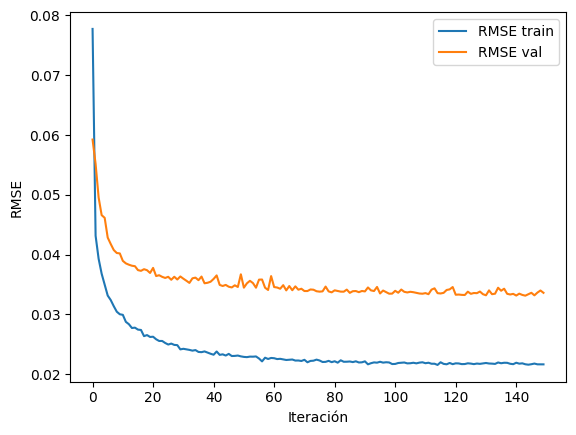

In [73]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### desempeño

In [74]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo8.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo8.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo8.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.019
  RMSE val:	 0.034
  RMSE test:	 0.024


In [75]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo8, scaler)

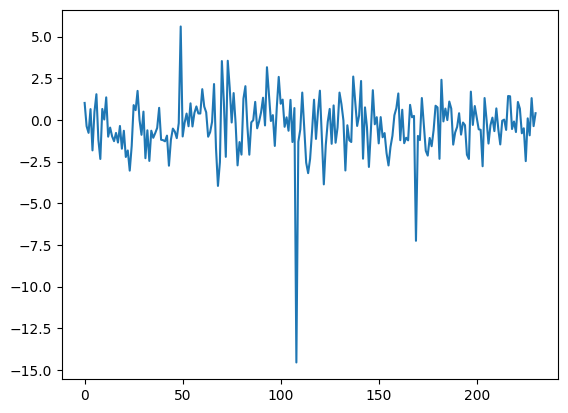

In [76]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [77]:
import datetime

start_date = datetime.datetime(2024, 6, 12)
curr_date = start_date

list_date = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(days=1)
    list_date.append(curr_date)

In [78]:
pred_series = pd.Series(data=y_ts_pred, index=list_date)
print(pred_series)

2024-06-13    106.508713
2024-06-14    107.617981
2024-06-15    107.553864
2024-06-16    107.114685
2024-06-17    107.982758
                 ...    
2025-01-25     94.088585
2025-01-26     94.315056
2025-01-27     93.694756
2025-01-28     95.154457
2025-01-29     95.168976
Length: 231, dtype: float32


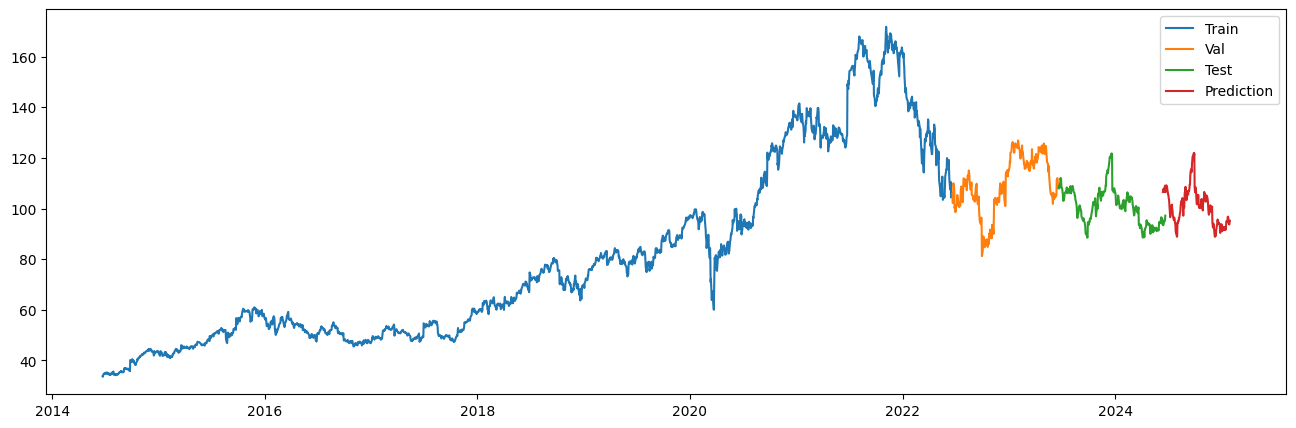

In [79]:
df_predicction = df.copy()

fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
ax.plot(pred_series, label='Prediction')
plt.legend();

In [89]:
ts_med = ts.mean()
pred_med = pred_series.mean()

diferencia = round(ts_med - pred_med, 2)
print(diferencia)

0.22


# 7. Conclusiones

- Uno de los mejores modelos que pudimos obtener fue el modelo 8, ya que este presenta un RMSE de train: 0.019, val: 0.034, test: 0.024.

- Para poder obtener este modelo, fue necesario disminuir la cantidad de batch size, aumentar las neuronas de la primera capa y agregar una segunda capa.

- Después de varias pruebas, se observaron los siguientes patrones que llevaron a la conclusión de que este era el mejor modelo: por ejemplo, al agregar una tercera capa, los resultados se mantenían constantes; al aumentar el batch size, el RMSE aumentaba; y al agregar un dropout, también aumentaba el RMSE.

- Como se puede observar en las predicciones, estas no están tan alejadas del set de test, ya que presentan la misma forma o valores similares.

- Los resultados son muy similares a los del modelo 6. Esto sugiere que aumentar la cantidad de neuronas no parece ser efectivo, ya que en el modelo 6, al incrementar el número de épocas, se observó una mejora en el rendimiento. Por lo tanto, se puede considerar que, si se hubiera entrenado por más tiempo, probablemente se habrían obtenido los mismos resultados.

- Hay una diferencia aproximada de 0.22 dólares entre los valores reales y los valores predichos.